# Selection of the optimal size of the dense layer of the neural network

## Contents
* [Task description](#Task-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Task description

To study the effect of the dense layer size in VGG7 for MNIST classification task.


## The parameters studied
Size of the last dense layer in VGG7. 

## Parameters Value Area
The output dimension of the last dense layer is determined by number of classes.

Therefore we can vary only the first dimension in the dense layer: 4096, 1024, 256, 10

## Metrics
Accuracy on the test set of the MNIST data.


In [1]:
import os
import sys
sys.path.insert(0, os.path.join("..", ".."))

from batchflow import B, V, C
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7
from batchflow.research import Option, Research, Results

from src import get_accuracy, show_research

## Dataset loading

In [3]:
mnist_ds = MNIST()

Extracting /tmp/train-labels-idx1-ubyte.gz
ExtractingDownloading  /tmp/train-images-idx3-ubyte.gzhttp://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


# Creating a model template
We use VGG7 model with to dense layers in the end of the network.
Define model config:

In [4]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                   labels=dict(classes=10, transform='ohe', name='targets')),
    'initial_block/inputs': 'images',
    'head': dict(layout='dfa f',
                 units=[C('n_filters'), 10]),
    'loss': 'ce',
    'optimizer': 'Adam',
}

feed_dict = {
    'images': B('images'),
    'labels': B('labels')
}

Define train and test pipeline and set parameters of lazy run with BATCH_SIZE = 60:

In [1]:
BATCH_SIZE = 60

In [5]:
train_pipeline = (
    mnist_ds.train.p
    .init_variable('loss', init_on_each_run=list)
    .init_model('dynamic', VGG7, 'mnist_model', config=model_config)
    .to_array()
    .train_model('mnist_model', fetches='loss', 
                 feed_dict=feed_dict, save_to=V('loss'), mode='w')
    .run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)
)

test_pipeline = (
    mnist_ds.test.p
    .import_model('mnist_model', C('import_from'))
    .init_variable('predictions', init_on_each_run=list)
    .init_variable('metrics', init_on_each_run=None)
    .to_array()
    .predict_model('mnist_model', fetches='predictions', 
                   feed_dict=feed_dict,
                   save_to=V('predictions'))
    .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', axis=-1, save_to=V('metrics'), mode='u')
    .run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)
)

# Creating a research object


Set the parameters for research execution:

For each parameter set perform NUM_ITERS=1000 iterations of train pipeline with model performance evaluation every 50 iterations. Repeat this procedure NUM_REPEAT=3 times.

We add to the research a function get_accuracy that gets results of the test pipeline and will be executed every 50 iterations.

Results of the research execution will be saved in the directory __n_filters_research__

In [6]:
hyper = Option('n_filters', [4096, 1024, 256, 10])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%50', run=True, import_from='train')
            .grid(hyper)
            .function(get_accuracy, returns='accuracy', name='test_accuracy',
                      execute='%50', pipeline='test'))

Run research:

In [2]:
N_REPS = 3
N_ITERS = 1000

In [7]:
research_name = 'n_filters_research'
research.run(n_reps=N_REPS, n_iters=N_ITERS, name=research_name, progress_bar=True)

Research n_filters_research is starting...


  0%|          | 0/12000 [00:00<?, ?it/s]

Distributor has 12 jobs with 1000 iterations. Totally: 12000


100%|██████████| 12000/12000 [24:20<00:00,  8.21it/s]


## Results

Train loss and test accuracy functions vs a number of iterations for each parameters set:

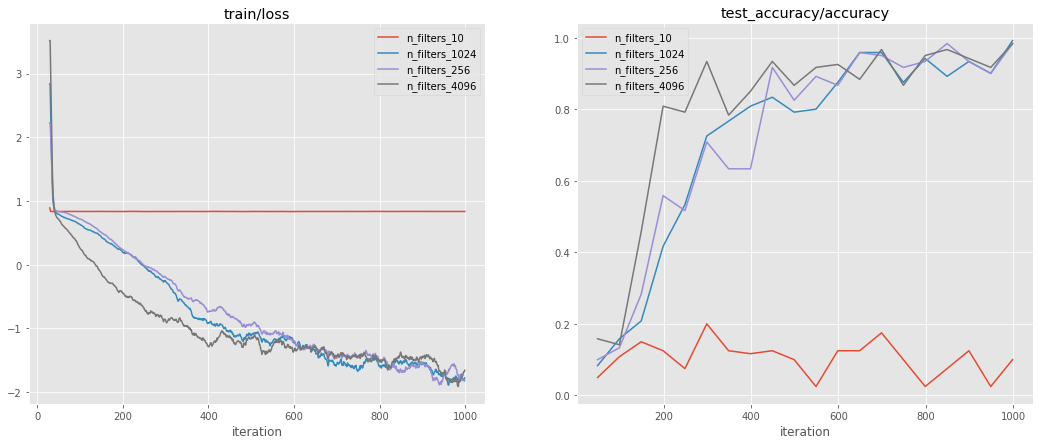

In [8]:
data = Results(path=research_name).load(use_alias=True)
show_research(data, average_repetitions=True, log_scale=[True, False],
              layout=['train/loss', 'test_accuracy/accuracy'], rolling_window=[30, None])

# Results

The model with the size 10 lacks a generalizing ability and its accuracy is kept at the level of 10%.

Models with 256, 1024 and 4096 size show approximately the same quality. This means that to achieve this quality, large models contain an excessive number of parameters and it is enough to have the last layer with size 256x10.

Recommended value: __256__.